# Sample Vegas ROI processing with Geopandas


In [75]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from IPython.display import display
import matplotlib.pyplot as plt
import osmnx as ox
from shapely.geometry import *

import sys, os, pdb
from collections import Counter

%matplotlib inline

---
## Helper functions

### I/O helpers

In [73]:
def to_geojson(df, fname):
    df.to_file(fname, driver='GeoJSON')
    
def get_geom_types(gdf):
    geom = gdf.geom_type
    return Counter(geom)

### Analysis helpers

In [73]:
# print(roads_utm.geometry[:5])
# Get ROI bounding box in lat/lon
def get_bbox(gdf):
    """
    Given a gpd.DataFrame, compute the boudning box for the entire dataset.
    The same unit of the original `gdf` will be used for the output bounding box (ie.roi)
    
    Args:
    - gdf (geopandas.DataFrame)
    Returns:
    - bbox (shapely.Polygon)
    """
    bounds = gdf.bounds
    minx,miny = bounds[['minx', 'miny']].min()
    maxx, maxy = bounds[['maxx', 'maxy']].max()
    bbox = Polygon( [(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)] )
    return bbox

def test_get_bbox():
    bbox = get_bbox(orig_roads)
    display(bbox)
test_get_bbox()

### Visualization helpers

In [73]:
def compare_with_osm(orig_roads, orig_blds):
    """
    orig_roads (gdf) in lat/lon
    orig_blds (gdf) in lat/lon
    """
#     from shapely.geometry import LineString, MultiLineString, Polygon
    roads_roi = get_roi(orig_roads)
    blds_roi = get_roi(orig_blds)
    roi = roads_roi.intersection(blds_roi)
    
    # Get osm data
    osm_blds = ox.footprints_from_polygon(roi) #expects lat/lon roi
    osm_roads_nx = ox.graph_from_polygon(roi)
    osm_roads = ox.graph_to_gdfs(osm_roads_nx)[1]
    
    # Plot
    f.suptitle(f"roi: {roi.bounds}")
    f,ax = plt.subplots(1,2,figsize=(20,20))
    ax = ax.flatten()
    orig_roads.plot(ax=ax[0], color='b')
    orig_blds.plot(ax=ax[0], color='r')

    osm_roads.plot(ax=ax[1],color='b')
    osm_blds.plot(ax=ax[1], color='r')
    for i,t in enumerate(['spacenet', 'osm']):
        ax[i].set_title(t)
        
    return osm_roads, osm_blds

def plot_two_gdfs(gdf0, gdf1, figsize=(30,30), titles=None):
    """
    Assumes gdf0 and gdf1 are in the same CRS
    """
    
    f,ax = plt.subplots(figsize=figsize)
    if titles is None:
        titles = ['0','1']
    gdf0.plot(ax=ax,color='k', alpha=0.5, label=titles[0])
    gdf1.plot(ax=ax,color='y', alpha=0.5, label=titles[1])
    ax.legend()
    return f, ax    
    

---
## Set additional paths

In [79]:
this_nb_dir = Path(os.getcwd())
ROOT = this_nb_dir.parent.parent
SRC = ROOT/'src'
DATA_DIR = ROOT/'data/raw'
paths2add = [this_nb_dir, ROOT, SRC]

INTRIM_DATA_DIR = DATA_DIR.parent/'processed'

print("Project root: ", str(ROOT))
print("this nb path: ", str(this_nb_dir))
print('src folder: ', str(SRC))
print('raw data folder: ', str(DATA_DIR))
print('processed data folder: ', INTRIM_DATA_DIR)

Project root:  /Users/hayley/Playground/PythonGIS
this nb path:  /Users/hayley/Playground/PythonGIS/notebook/examples
src folder:  /Users/hayley/Playground/PythonGIS/src
raw data folder:  /Users/hayley/Playground/PythonGIS/data/raw
processed data folder:  /Users/hayley/Playground/PythonGIS/data/processed


In [26]:
for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(str(p), "added to the path\n")
        
print(sys.path)

/Users/hayley/Playground/PythonGIS added to the path

/Users/hayley/Playground/PythonGIS/src added to the path

['/Users/hayley/Playground/PythonGIS/src', '/Users/hayley/Playground/PythonGIS', '/Users/hayley/Playground/PythonGIS/notebook/examples', '/', '/Users/hayley/miniconda3/envs/test/lib/python36.zip', '/Users/hayley/miniconda3/envs/test/lib/python3.6', '/Users/hayley/miniconda3/envs/test/lib/python3.6/lib-dynload', '', '/Users/hayley/miniconda3/envs/test/lib/python3.6/site-packages', '/Users/hayley/miniconda3/envs/test/lib/python3.6/site-packages/IPython/extensions', '/Users/hayley/.ipython']


### Load datasets

In [30]:
# Paths to the road and building datasets
RPATH = DATA_DIR/'vegas_train_sample/vegas_train_sample_roads/vegas_sample_roads.shp' #Roads shape file
BPATH = DATA_DIR/'vegas_train_sample/vegas_train_sample_buildings/vegas_sample_buildings.shp' #Buildings shape file          

In [32]:
orig_roads = gpd.read_file(str(RPATH))
orig_blds = gpd.read_file(str(BPATH))

---
## Initial data exploration

In [33]:
print(f'number of road features: {len(orig_roads)}')
print(f'number of building features: {len(orig_blds)}')

number of road features: 6477
number of building features: 35124


In [34]:
orig_roads.head();
print("Original road CRS: ", orig_roads.crs['init'])
print("Original blds CRS: ", orig_blds.crs['init'])

# orig_roads.to_file(str(RPATH.parent/'vegas_sample_roads.geojson'),
#              driver='GeoJSON');

Original road CRS:  epsg:4326
Original blds CRS:  epsg:4326


Vegas train sample road data consists of both `LineString` and `MultiLineString` geometry objects. 

In [35]:
Counter(orig_roads.geom_type)

Counter({'LineString': 6306, 'MultiLineString': 171})

In [36]:
orig_mlines = orig_roads [orig_roads.geom_type == 'MultiLineString']
print(len(orig_mlines))
orig_mlines.head()

171


,bridge_typ,heading,lane_numbe,lane_num_1,one_way_ty,paved,road_id,road_type,origarea,origlen,partialDec,truncated,layer,path,geometry
27,2,0,2,2,2,1,4119,5,0,0.00474,1,0,spacenetroads_AOI_2_Vegas_img259,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,"(LINESTRING (-115.27787390967 36.15150133189, ..."
59,2,0,2,2,2,1,23109,6,0,0.00371,1,0,spacenetroads_AOI_2_Vegas_img262,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,"(LINESTRING (-115.27809218114 36.16015563588, ..."
77,2,0,2,2,2,1,22411,5,0,0.00478,1,0,spacenetroads_AOI_2_Vegas_img262,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,"(LINESTRING (-115.27686337298 36.16271489136, ..."
84,2,0,1,1,2,1,189,6,0,0.00407,1,0,spacenetroads_AOI_2_Vegas_img262,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,"(LINESTRING (-115.27787997948 36.16018699134, ..."
131,2,0,2,2,2,1,8034,5,0,0.00346,1,0,spacenetroads_AOI_2_Vegas_img266,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,"(LINESTRING (-115.27707129861 36.17700220785, ..."


A `MultiLineString` object is a list of `LineString` objects:

LINESTRING (-115.27787390967 36.15150133189, -115.27789740279 36.15195643095, -115.27789953626 36.15201118994, -115.27794505023 36.15267967629, -115.277964334691 36.1528676998)


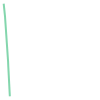

LINESTRING (-115.2788858186808 36.15195827569502, -115.27880128168 36.15195429748, -115.2780047873 36.15195714211)


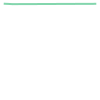

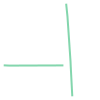

MultiLineString


In [37]:
temp = orig_mlines.iloc[0,-1]
for t in temp:
    print(t)
    display(t)
display(temp)
print(temp.geom_type)

What is the average number of lines per multiline instance?

In [38]:
orig_mlines['num_lines'] = [ len(geom) for geom in orig_mlines.geometry] #or, list(map(len, orig_mlines.geometry))
print('Average num of lines per multiline: ', orig_mlines['num_lines'].mean())

Average num of lines per multiline:  2.046783625730994


/Users/hayley/miniconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Project original road and building datasets to UTM
We are interested in collecting a local, area-based geostatistics around sample points along each road in our dataset. 
In order to do so, we first need to be able to compute the length of `LineString` objects, which requires us to project the original datasets to proper UTM crs. `osmnx` has a convenient function to automatically figure out the correct UTM zone based on the lat/lon values of the geometries. So here we are going to use `osmnx.project_gdf` function to project our original datasets from lat/lon (ie. `EPSG:4326`) to proper UTM zone. Our current dataset is in Las Vegas, whose UTM is "zone 11s". 


In [39]:
orig_roads_utm = ox.project_gdf(orig_roads)
orig_blds_utm = ox.project_gdf(orig_blds)

In [40]:
orig_roads_utm.head()

,bridge_typ,heading,lane_numbe,lane_num_1,one_way_ty,paved,road_id,road_type,origarea,origlen,partialDec,truncated,layer,path,geometry
0,2,0,2,2,2,1,6225,6,0,0.00295,1,0,spacenetroads_AOI_2_Vegas_img256,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,LINESTRING (655114.1071653127 4001107.98441977...
1,2,0,2,2,2,1,14427,6,0,0.00370,1,0,spacenetroads_AOI_2_Vegas_img256,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,LINESTRING (655005.3872435102 4001110.71488258...
2,2,0,1,1,2,1,22769,6,0,0.00118,1,0,spacenetroads_AOI_2_Vegas_img256,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,LINESTRING (655046.1012648831 4001052.01737247...
3,2,0,1,1,2,1,10952,6,0,0.00111,1,0,spacenetroads_AOI_2_Vegas_img256,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,LINESTRING (654983.696096173 4001052.515931114...
4,2,0,1,1,2,1,22261,6,0,0.00154,1,0,spacenetroads_AOI_2_Vegas_img256,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,LINESTRING (655045.7294525619 4001068.52934153...


In [55]:
orig_blds_utm.head(10)

In [64]:
# each column content examination
## Roads
print(orig_roads.columns)
print("duplicates?: ", orig_roads['lane_numbe'].equals(orig_roads['lane_num_1']))
keep_road_cols = ['road_id', 'road_type', 'lane_numbe','geometry']
roads_utm = orig_roads_utm[keep_road_cols]

    

Index(['bridge_typ', 'heading', 'lane_numbe', 'lane_num_1', 'one_way_ty',
       'paved', 'road_id', 'road_type', 'origarea', 'origlen', 'partialDec',
       'truncated', 'layer', 'path', 'geometry'],
      dtype='object')
duplicates?:  True


In [66]:
roads_utm.head(10)

,road_id,road_type,lane_numbe,geometry
0,6225,6,2,LINESTRING (655114.1071653127 4001107.98441977...
1,14427,6,2,LINESTRING (655005.3872435102 4001110.71488258...
2,22769,6,1,LINESTRING (655046.1012648831 4001052.01737247...
3,10952,6,1,LINESTRING (654983.696096173 4001052.515931114...
4,22261,6,1,LINESTRING (655045.7294525619 4001068.52934153...
5,11028,6,2,"LINESTRING (654911.5333190199 4001107.1937237,..."
6,6579,6,2,LINESTRING (654870.9695682032 4001108.33130987...
7,14900,5,2,LINESTRING (654842.8318126452 4001503.56574427...
8,20042,5,2,LINESTRING (654957.1779358039 4001584.91284545...
9,3360,5,2,LINESTRING (654867.8376925564 4001661.45244692...


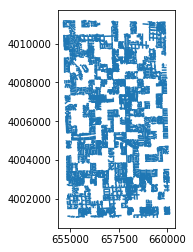

In [67]:
roads_utm.plot()

In [68]:
## Slimify blds dataframe with only relevant information
for i, c in enumerate(orig_blds.columns):
    if c in ['path', 'layer', 'geometry']:
        continue
    print("="*80)
    print(i, c)
    print(np.unique(orig_blds[c]))

0 Name
['Ashok' 'Doubt' 'None']
1 AREA
[0.00000000e+00 3.67876200e+00 3.98151300e+00 ... 3.68248835e+03
 3.87952027e+03 6.46891975e+03]
2 Shape_Leng
[0.]
3 Shape_Le_1
[0.]
4 SISL
[0.]
5 Shape_Le_2
[   0.          5.694699    5.77474  ...  874.63338  1123.29875
 1274.765934]
6 Shape_Le_3
[1.0000e-06 2.0000e-06 4.0000e-06 ... 1.0241e-02 1.1358e-02 1.3573e-02]
7 Shape_Area
[0.e+00 1.e-06 2.e-06 3.e-06]
8 partialBui
[0. 1.]
9 partialDec
[0.00000e+00 1.00000e-06 2.00000e-06 ... 9.99998e-01 9.99999e-01
 1.00000e+00]


In [70]:
keep_bld_cols = ['AREA', 'geometry']
blds_utm = orig_blds_utm[keep_bld_cols]
print(blds_utm.head(10))

   AREA                                           geometry
0   0.0  POLYGON Z ((654887.6843301055 4004966.73146603...
1   0.0  POLYGON Z ((654878.6859315988 4004808.68980997...
2   0.0  POLYGON Z ((654889.9826662034 4004837.24133682...
3   0.0  POLYGON Z ((654889.1587552386 4004883.66156700...
4   0.0  POLYGON Z ((654888.5115288519 4004920.12682993...
5   0.0  POLYGON Z ((654873.4697422066 4005567.27646592...
6   0.0  POLYGON Z ((654875.5943337854 4005516.56284072...
7   0.0  (POLYGON Z ((654877.2146453245 4005556.5564011...
8   0.0  POLYGON Z ((654853.3841794071 4005499.28468149...
9   0.0  POLYGON Z ((654849.3048140666 4005587.16514664...


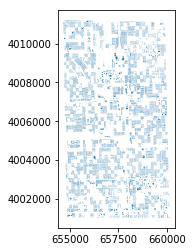

In [71]:
blds_utm.plot()

In [80]:
## pickle intermediate data
# joblib.dump(roads_utm, str(INTRIM_DATA_DIR/'raods_utm.pkl'))
# joblib.dump(blds_utm, str(INTRIM_DATA_DIR/'blds_utm.pkl'))

['/Users/hayley/Playground/PythonGIS/data/processed/blds_utm.pkl']

---
## Sample points along the roads with a fixed interval

In [78]:
def createPointsAlongLine(geom, distance, pts):
    """
    Args:
    
    - geom: LineString or MultiLineString
    - distance (float): distance between points to be sampled along the line(s)
    - pts (list:non-const): points will be added to this list
    """
    
    if not isinstance(geom, (MultiLineString, LineString)):
        print(type(geom))
        pdb.set_trace()
        raise ValueError("Input geometry should be either MultiLineString or LineString"
                        f": {type(geom)}")
        
    if distance > geom.length:
        print('Done!')
    
    if isinstance(geom, MultiLineString):
        for g in geom:
            createPointsAlongLine(distance, g, pts) 
    elif isinstance(geom, LineString): #basecase
        length = geom.length
        currentdistance = distance
        while currentdistance < length: 
            pt = geom.interpolate(currentdistance)
            pts.append(pt)
            currentdistance = currentdistance + distance


In [63]:
mlines_utm = ox.project_gdf(multilines)
mlines_utm.head()

,bridge_typ,heading,lane_numbe,lane_num_1,one_way_ty,paved,road_id,road_type,origarea,origlen,partialDec,truncated,layer,path,geometry
27,2,0,2,2,2,1,4119,5,0,0.00474,1,0,spacenetroads_AOI_2_Vegas_img259,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,(LINESTRING (654920.871602067 4002126.08222450...
59,2,0,2,2,2,1,23109,6,0,0.00371,1,0,spacenetroads_AOI_2_Vegas_img262,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,(LINESTRING (654884.2067728946 4003085.7806647...
77,2,0,2,2,2,1,22411,5,0,0.00478,1,0,spacenetroads_AOI_2_Vegas_img262,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,(LINESTRING (654989.7076105331 4003371.6479636...
84,2,0,1,1,2,1,189,6,0,0.00407,1,0,spacenetroads_AOI_2_Vegas_img262,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,(LINESTRING (654903.2341938438 4003089.5976412...
131,2,0,2,2,2,1,8034,5,0,0.00346,1,0,spacenetroads_AOI_2_Vegas_img266,/Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...,(LINESTRING (654942.8670021349 4004956.2525227...


In [64]:
mline = mlines_utm.iloc[0].geometry

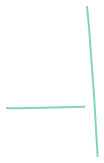

In [65]:
display(mline)

In [ ]:
### test
def test_createPoints():
    pts = []
    createPointsAlongLine(r0, 10, pts)
    display(collection.GeometryCollection(pts + [r0]))
    
def test_createPoints2():
    pts = []
    createPointsAlongLine(mline,10,  pts)
    display(collection.GeometryCollection(pts + [*mline]))
    
def test_createPoints3():
    pts = []
    mlines = multilines[:10]
    for i in range(len(mlines)):
        geom = mlines.iloc[[i]].geometry.item()
        createPointsAlongLine(geom, 10, pts)
    print(len(pts))
    display(collection.GeometryCollection(pts + [*mline]))

test_createPoints3()

<class 'geopandas.geoseries.GeoSeries'>
> <ipython-input-78-e22da7131bcf>(13)createPointsAlongLine()
-> raise ValueError("Input geometry should be either MultiLineString or LineString"


In [72]:
geom

NameError: name 'geom' is not defined

In [ ]:
for l in mline:
    print(l.length)
print(mline.length)
print(mline[0].bounds)

In [ ]:
p = mline.interpolate(50)

In [ ]:
from shapely.geometry import collection


In [18]:
temp = collection.GeometryCollection([mline, p])


NameError: name 'collection' is not defined

In [ ]:
display(temp)

In [ ]:
all_pts = []
d = 5
nRoads = len(orig_roads_utm)
for i in range(nRoads):
    r = orig_roads_utm.iloc[i]
    rid = r['road_id']
    rtype = r['road_type']
    pts = []
    createPointsAlongLine(d, r.geometry, pts=pts)
    print(len(pts))
#     {'road_id': rid, 
#      'road_type': rtype,
#      'pts': pts}
    for pt in pts:
        all_pts.append( (rid, rtype, pt) )
        
    if len(all_pts) % 10 == 0:
#         if isinstance(r.geometry, MultiLineString):
#             temp = collection.GeometryCollection([*r]+pts)
#         elif isinstance(r.geometry, LineString):
#             temp = collection.GeometryCollection([r]+ pts)
#         display(temp)
        pdb.set_trace()
        
    

In [5]:
import pandas
pandas.D

In [289]:
data = [{'a':1, 'b':10}, {'a': 

,road_id
27,4119
59,23109
77,22411
84,189
131,8034
136,21179
176,14577
546,15414
568,8831
575,19799


In [38]:
blds = orig_blds[['AREA', 'Shape_Area', 'geometry']]
blds.head()

,AREA,Shape_Area,geometry
0,0.0,0.0,POLYGON Z ((-115.2776825999405 36.177105467830...
1,0.0,0.0,POLYGON Z ((-115.2778137964003 36.175682699824...
2,0.0,0.0,POLYGON Z ((-115.2776825999405 36.175938187824...
3,0.0,0.0,POLYGON Z ((-115.2776825999405 36.176356639872...
4,0.0,0.0,POLYGON Z ((-115.2776825999405 36.176685353516...


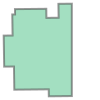

'area: 0.0'

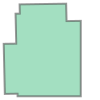

'area: 0.0'

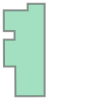

'area: 0.0'

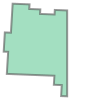

'area: 0.0'

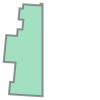

'area: 0.0'

In [47]:
for i in range(5):
    display(blds.iloc[i].geometry, f'area: {blds.iloc[i].AREA}')

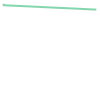

'6, len: 0.00295'

> <ipython-input-52-cd259fe41155>(1)<module>()
-> for i in range(5):


(Pdb)  row


bridge_typ                                                    2
heading                                                       0
lane_numbe                                                    2
lane_num_1                                                    2
one_way_ty                                                    2
paved                                                         1
road_id                                                    6225
road_type                                                     6
origarea                                                      0
origlen                                                 0.00295
partialDec                                                    1
truncated                                                     0
layer                          spacenetroads_AOI_2_Vegas_img256
path          /Users/hayley/data/AOI_2_Vegas_Roads_Train/geo...
geometry      LINESTRING (-115.2759276 36.14229570682239, -1...
Name: 0, dtype: object


(Pdb)  c


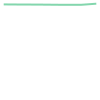

'6, len: 0.0037'

> <ipython-input-52-cd259fe41155>(1)<module>()
-> for i in range(5):


(Pdb)  c


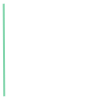

'6, len: 0.00118'

> <ipython-input-52-cd259fe41155>(1)<module>()
-> for i in range(5):


(Pdb)  c


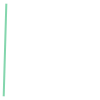

'6, len: 0.00111'

> <ipython-input-52-cd259fe41155>(1)<module>()
-> for i in range(5):


(Pdb)  c


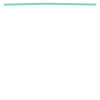

'6, len: 0.00154'

> <ipython-input-52-cd259fe41155>(1)<module>()
-> for i in range(5):


(Pdb)  c


In [52]:
for i in range(5):
    row = roads.iloc[i]
    display(roads.iloc[i].geometry, f'{roads.iloc[i].road_type}, len: {roads.iloc[i].origlen}')
    pdb.set_trace()

---
## [optional]  OSM data vs Spacenet Data
Compare the road and building data from OSM with the Spacenet challenge's (more-curated) datasets


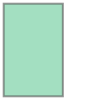

In [72]:
# print(roads_utm.geometry[:5])
# Get ROI bounding box in lat/lon
def get_bbox(gdf):
    """
    Given a gpd.DataFrame, compute the boudning box for the entire dataset.
    The same unit of the original `gdf` will be used for the output bounding box (ie.roi)
    
    Args:
    - gdf (geopandas.DataFrame)
    Returns:
    - bbox (shapely.Polygon)
    """
    bounds = gdf.bounds
    minx,miny = bounds[['minx', 'miny']].min()
    maxx, maxy = bounds[['maxx', 'maxy']].max()
    bbox = Polygon( [(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)] )
    return bbox

def test_get_bbox():
    bbox = get_bbox(orig_roads)
    display(bbox)
test_get_bbox()

In [27]:
# Get building footprints using osmnx
# ox_blds = ox.create_buildings_gdf(north=maxy, south=miny, east=minx, west=maxy)

# gdf = ox.buildings_from_point(point=(miny, minx), distance=1000)
roi = get_roi(orig_roads) 
osm_blds = ox.footprints_from_polygon(roi)
osm_road_nx = ox.graph_from_polygon(roi)
osm_roads = ox.graph_to_gdfs(osm_road_nx)[1]

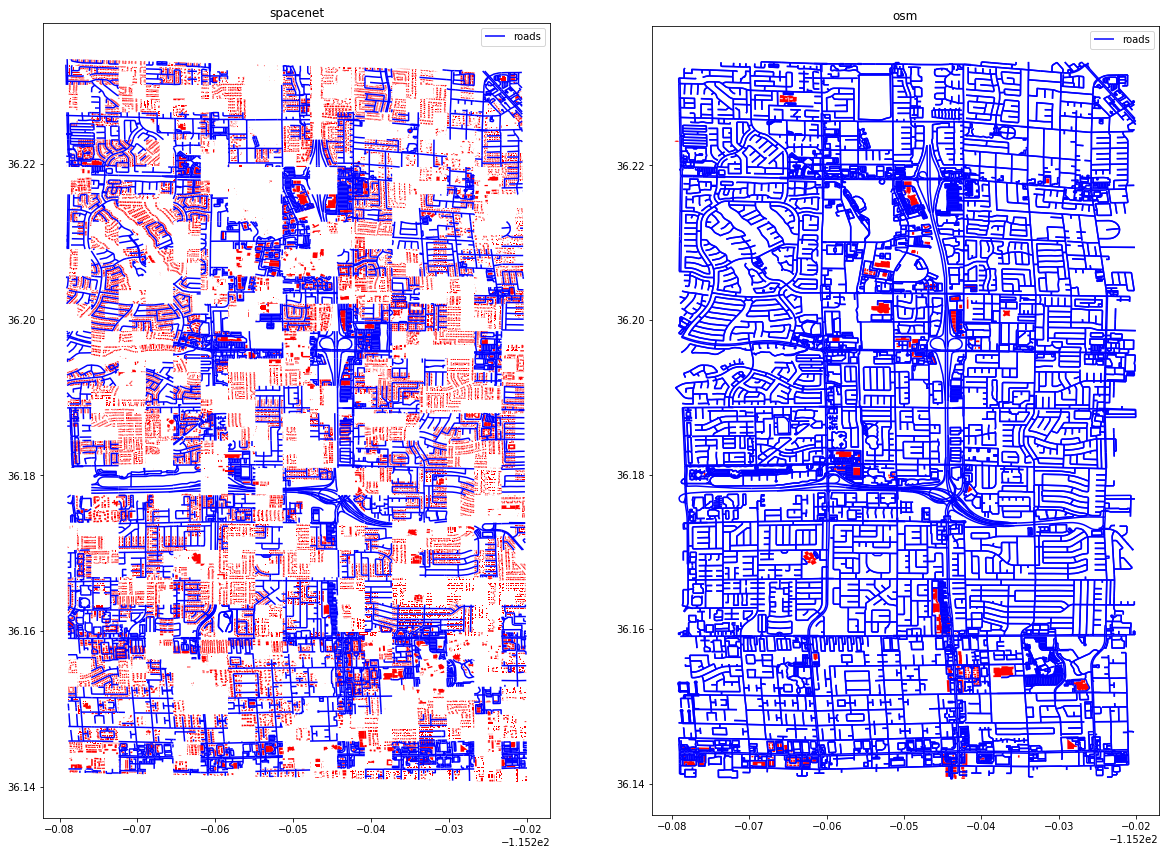

In [33]:
f2,ax2 = plt.subplots(1,2,figsize=(20,20))
ax2 = ax2.flatten()
orig_roads.plot(ax=ax2[0], color='b', label='roads')
orig_blds.plot(ax=ax2[0], color='r', label='blds')

osm_roads.plot(ax=ax2[1],color='b', label='roads')
osm_blds.plot(ax=ax2[1], color='r', label='blds')
for i,t in enumerate(['spacenet', 'osm']):
    ax2[i].set_title(t)
    ax2[i].legend()

Text(0.5, 1.0, 'roi: (-115.27918115232819, 36.14077299188275, -115.22001822156085, 36.233402942435625)')

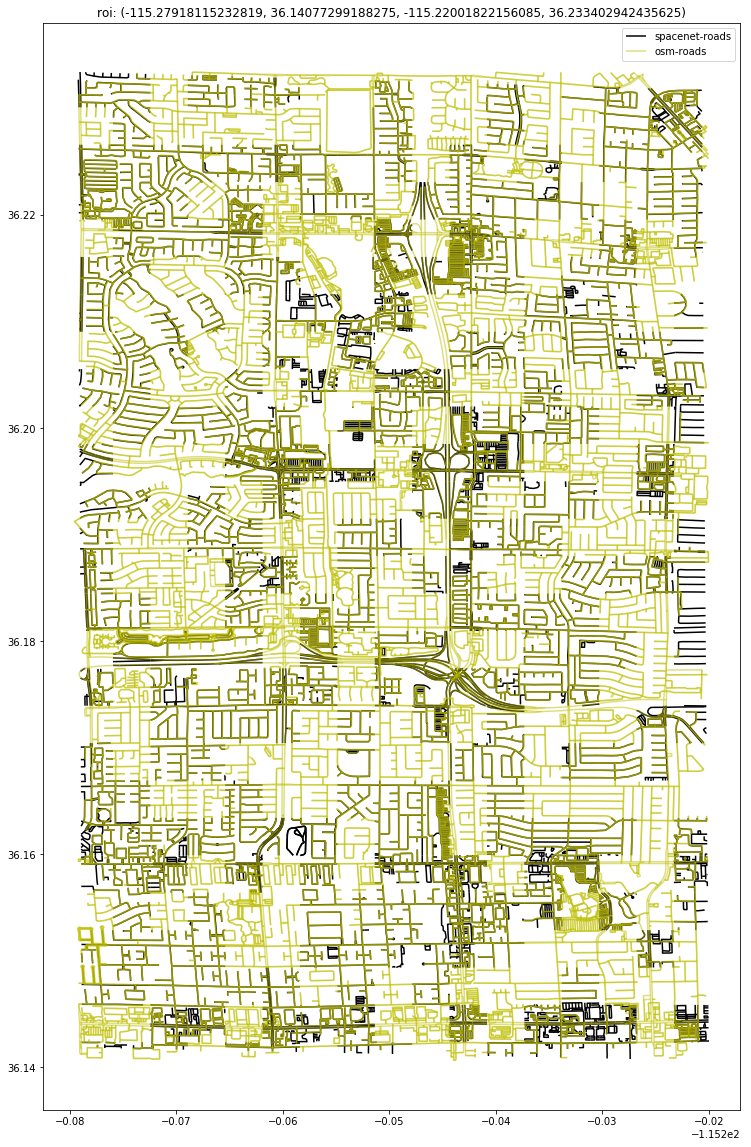

In [31]:
f,ax = plt.subplots(figsize=(20,20))
orig_roads.plot(ax=ax,color='k',alpha=1, label='spacenet-roads')
osm_roads.plot(ax=ax, color='y',alpha=0.5,label='osm-roads')
ax.legend()
ax.set_title(f"roi: {roi.bounds}")

In [ ]:
f2

In [ ]:
f3,ax3 = plt.subplots(figsize=(30,30))
orig_roads.plot(ax=ax3, color='b')
osm_roads.plot(ax=ax3, color='r')

In [ ]:
orig_roads['origlen'][:10]
orig_roads.geometry[:5]

In [ ]:
orig_blds.head()

In [ ]:
import fiona
meta
with fiona.open(str(RPATH)) as src:
    meta = src.meta
    print(meta['schema']['geometry'])
    pdb.set_trace()

In [ ]:
mata

In [ ]:
## helpers
# add background tiles to plot
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, ll=True, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    return basemap, extent
# webmercator: EPSG:3857, EPSG:3785, OpenLayers:900913

No handles with labels found to put in legend.


NameError: name 'add_basemap' is not defined

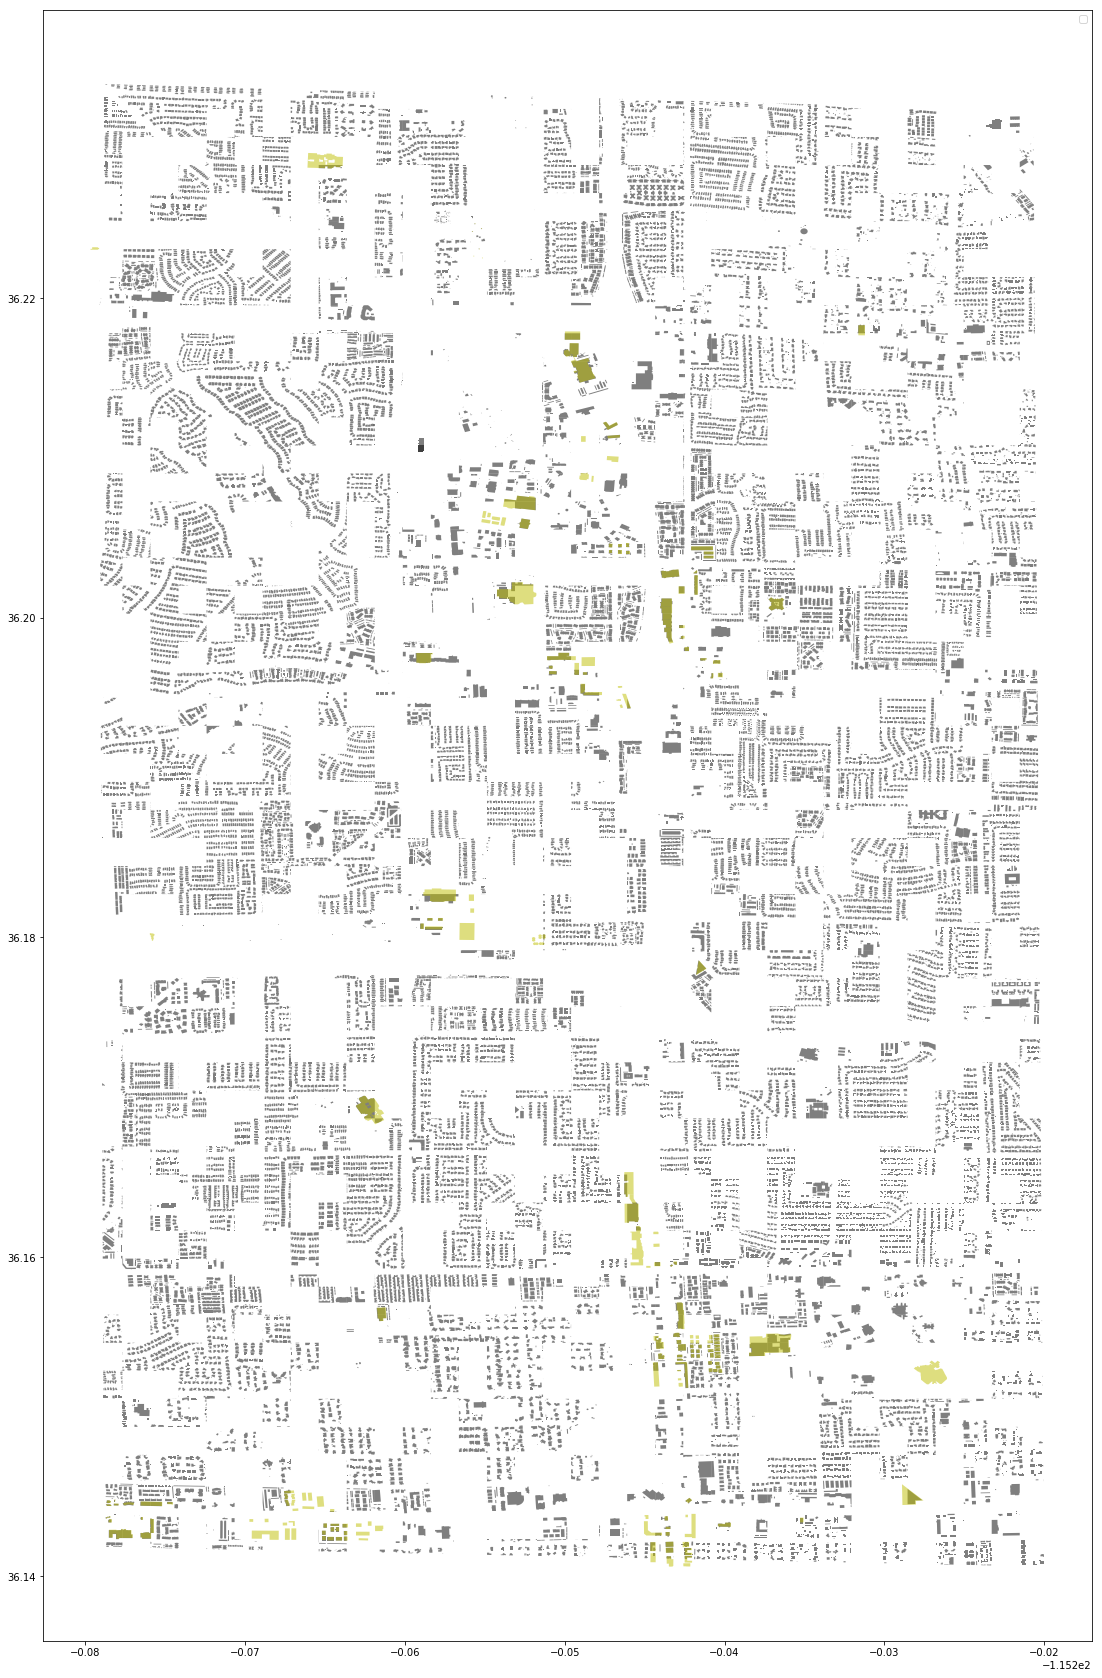

In [34]:
# plot_two_gdfs(orig_roads, osm_roads)
def test_plot_two_gdfs():  
    _, ax = plot_two_gdfs(orig_blds, osm_blds)
    basemap, extent = add_basemap(ax, zoom=13)
    print(extent)
    pdb.set_trace()
    
test_plot_two_gdfs()